
This google colab notebook:

1.   Downloads the SIMFLUX code (https://github.com/jcnossen/sf2.git)
2.   Clones and builds the C++/CUDA PSF fitting code https://gitlab.com/jcnossen/fastpsf.git
3.   Simulates a microtubule dataset with random spline curves
4.   Performs localization, simflux localization, frc calculation and rendering.

Make sure to select a GPU-enabled runtime in the google colab runtime type

In [1]:
# %%capture will hide the output
%cd /content
!rm -rf /content/fastpsf
!git clone https://gitlab.com/jcnossen/fastpsf.git
%cd /content/fastpsf
!cmake .
!make clean & make
%cd /content/fastpsf/python/
!python setup.py develop

/content
Cloning into 'fastpsf'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 295 (delta 18), reused 0 (delta 0), pack-reused 249
Receiving objects: 100% (295/295), 148.89 KiB | 1.15 MiB/s, done.
Resolving deltas: 100% (139/139), done.
/content/fastpsf
-- The CXX compiler identification is GNU 9.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for a CUDA compiler
-- Looking for a CUDA compiler - /usr/local/cuda/bin/nvcc
-- The CUDA compiler identification is NVIDIA 11.8.89
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
Targeting CUD

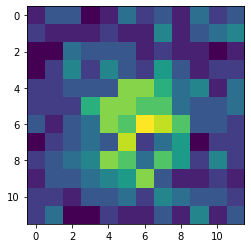

In [2]:
# Check that fastpsf + CUDA is running ok by evaluating a 2D Gaussian..
from fastpsf import Context, GaussianPSFMethods
import matplotlib.pyplot as plt

with Context() as ctx:
  roisize =12
  psf = GaussianPSFMethods(ctx).CreatePSF_XYIBg(roisize, sigma = 2, cuda=True)
  plt.imshow(psf.GenerateSample([[roisize/2,roisize/2,200,2]])[0])



Clone simflux code

In [3]:
# %%capture will hide the output
#%%capture
%cd /content
!rm -rf /content/simflux2
!git clone https://gitlab.com/qnano/simflux2.git
%cd /content/simflux2
!python setup.py develop

/content
Cloning into 'simflux2'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 56 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (56/56), 1.40 MiB | 5.79 MiB/s, done.
/content/simflux2
['smlmtorch', 'smlmtorch.ui', 'smlmtorch.simflux']
running develop
/usr/local/lib/python3.9/dist-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running egg_info
creating simflux.egg-info
writing simflux.egg-info/PKG-INFO
writing dependency_links to simflux.egg-info/dependency_links.txt
writing requirements to simflux.egg-info/requires.txt
writing

## Run simflux simulation

pos=1.001. step=0.007: : 101it [00:00, 841.46it/s]
pos=1.001. step=0.002: : 273it [00:00, 952.66it/s]
pos=1.001. step=0.002: : 244it [00:00, 608.07it/s]
pos=1.001. step=0.008: : 71it [00:00, 269.33it/s]
pos=1.001. step=0.003: : 180it [00:00, 976.47it/s]
pos=1.001. step=0.002: : 215it [00:00, 484.30it/s]
pos=1.023. step=0.077: : 149it [00:00, 420.51it/s]
pos=1.003. step=0.004: : 141it [00:00, 907.69it/s]
pos=1.001. step=0.003: : 224it [00:00, 469.76it/s]
pos=1.000. step=0.003: : 156it [00:00, 540.75it/s]


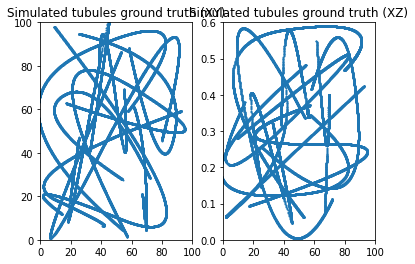

In [4]:
import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import smlmtorch.simflux.pattern_estimator as pe
import numpy as np
from smlmtorch.simflux.simulate import angles_to_mod
import matplotlib.pyplot as plt
from smlmtorch.ui.array_view import array_view
from smlmtorch.multipart_tiff  import MultipartTiffSaver
from smlmtorch import Dataset

from smlmtorch.simflux.simulate import simulate
from smlmtorch.simflux import SFLocalizer

import tqdm
from fastpsf import Context, GaussianPSFMethods, CSplineMethods, CSplineCalibration

from smlmtorch.util.generate_tubules import generate_microtubule_points
from smlmtorch.simflux.localizer_report import LocalizationReporter
from smlmtorch.simflux.pattern_estimator import ModulationPattern
from smlmtorch import struct


sim_roisize = 10  # simulation roisize
roisize = 10 # localization roisize

psf_calib = [1.8,1.8]
psf_label= 'gauss1.8px'

np.random.seed(0)

W = 100
Zrange = [0.1, 0.7]
pts = generate_microtubule_points(W, depth=Zrange[1]-Zrange[0], 
                                        numtubules = 10, 
                                        linedensity=20, margin=0)

on_fraction = 0.001
avg_on_time = 6
nframes = 5000
intensity = 1000

pts[:,2] += Zrange[0]

background = 4 # approximately dna paint background on our dmd setup
path = f'simulated/{psf_label}/sim_gauss2D_tubules_bg{background}_I{intensity}.tif'


pixelsize = 100
pattern_frames = np.array([[0,2,4], [1,3,5]])
mod = angles_to_mod([200, 200], pixelsize, [1, 91], 0.95, pattern_frames)

mp_gt = ModulationPattern(pattern_frames, mod)

cfg = struct(
   psf_calib= psf_calib,
   roisize=roisize,
   detection_threshold=2,
   pattern_frames= pattern_frames,
   gain= 1,
   offset= 0,
   pixelsize= pixelsize,
   zrange= Zrange, # [0.2, 0.6]# [-0.3, 1.3]
   debug_mode=False,
   psf_sigma_binsize = None,
   result_dir='results2'
)



In [5]:

#%% Simulation

psf_calib_sim = psf_calib
with Context() as ctx:
    psf = GaussianPSFMethods(ctx).CreatePSF_XYIBg(sim_roisize, psf_calib_sim, cuda=True)
    simulate(path, mp_gt, psf, 
         pts[:,:2], numframes=nframes, intensity=intensity, width=W, 
         bg=background, avg_on_time=avg_on_time, on_fraction=on_fraction)



  0%|          | 0/5000 [00:00<?, ?it/s]

p_off=0.999, k_on=0.000, k_off=0.042


#spots=203917: 100%|██████████| 5000/5000 [00:50<00:00, 98.10it/s] 


Reading sim_gauss2D_tubules_bg4_I1000.tif: 100%|██████████| 1/1 [00:00<00:00, 352.43it/s]


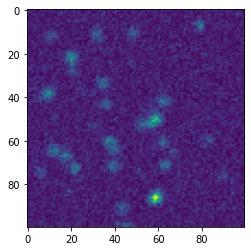

In [6]:
from smlmtorch.multipart_tiff import tiff_read_all
frame0 = tiff_read_all(path, 0, maxframes=1)[0]
plt.imshow(frame0)


### Perform regular SMLM on summed frames, and estimate intensities of each localization for each 6 different pattern exposures

Processing simulated/gauss1.8px/sim_gauss2D_tubules_bg4_I1000.tif with 5000 frames
moving_window=True


100%|█████████▉| 29970/30000 [00:14<00:00, 2077.11it/s]


Num ROIs: 137632


Fitting with known PSF sigma: 100%|██████████| 137632/137632 [00:02<00:00, 56304.20it/s]


Removing 0 localizations with NaN
Remaining localizations: 137407/137632
Chi-sq filtered: 135186/137407
Saving Picasso-compatible hdf5 to simulated/gauss1.8px/results2/sim_gauss2D_tubules_bg4_I1000/smlm.hdf5
Median intensity: 838. Bg: 24.95 Median CRLB: X=13.1 nm Y=13.1 nm. (0.13, 0.13 px)
numrois: 137632. #summed_fits: 137632


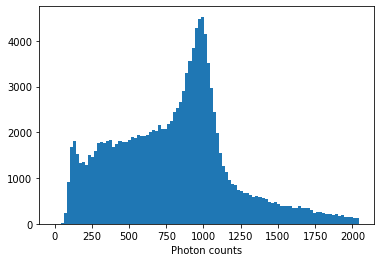

In [7]:

#%%
cfg['psf_calib'] = psf_calib
cfg['roisize'] = roisize
sfloc = SFLocalizer(path, **cfg, device='cuda:0')

sfloc.detect_spots(ignore_cache=False, moving_window=True)
smlm_ds = sfloc.fit_smlm(max_crlb_xy=None, ignore_cache=False)
print(f"numrois: {sfloc.numrois}. #summed_fits: {sfloc.summed_fits.shape[0]}")



Angle: 1.00, Pitch: 199.90 nm
Angle: 91.01, Pitch: 199.95 nm


100%|██████████| 26/26 [00:03<00:00,  6.57it/s]


Pattern 0: kx=3.1426 ky=0.0546 Phase     2.35 Depth= 0.94 Rel.Int=0.167 
Pattern 1: kx=-0.0554 ky=3.1419 Phase    -0.09 Depth= 0.94 Rel.Int=0.167 
Pattern 2: kx=3.1426 ky=0.0546 Phase   121.94 Depth= 0.95 Rel.Int=0.167 
Pattern 3: kx=-0.0554 ky=3.1419 Phase   119.60 Depth= 0.94 Rel.Int=0.167 
Pattern 4: kx=3.1426 ky=0.0546 Phase  -117.50 Depth= 0.94 Rel.Int=0.167 
Pattern 5: kx=-0.0554 ky=3.1419 Phase  -119.86 Depth= 0.94 Rel.Int=0.167 
Angle 0 shifts: [120.559 119.59 ] (deg) (patterns: [0 2 4]). Depth=0.940
Angle 1 shifts: [120.536 119.698] (deg) (patterns: [1 3 5]). Depth=0.940


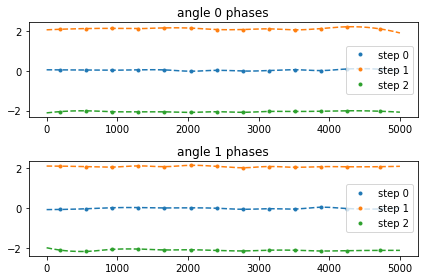

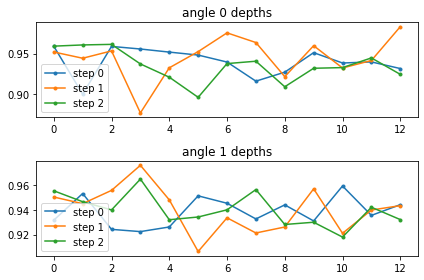

In [8]:

if nframes > 600 and W>40:
    mp_est = sfloc.estimate_angles(pitch_minmax_nm=[100,240])
    mp_est = sfloc.estimate_phases(mp_est, frame_binsize=10000, 
                                   accept_percentile=40, iterations=10, verbose=False)
    
else:
    mp_est=mp_gt

mp_est.print_info()
#lr = LocalizationReporter(sfloc.sum_ds, sfloc.result_dir, mp_est)
#lr.draw_patterns(2, me_threshold=0.1)

Using cached simulated/gauss1.8px/cache/sim_gauss2D_tubules_bg4_I1000/sf_fits
Saving Picasso-compatible hdf5 to simulated/gauss1.8px/results2/sim_gauss2D_tubules_bg4_I1000/sf.hdf5


/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


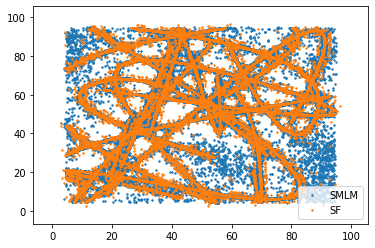

In [11]:
# Filter by modulation error
me = mp_est.mod_error(smlm_ds)
me_sel = me < 0.1

sf_ds = sfloc.fit_simflux(mp_est, smlm_ds[me_sel], iterations=50, lambda_=500, normalizeWeights=True, ignore_cache=False)

lr = LocalizationReporter(sfloc.sum_ds, sfloc.result_dir, mp_est)
lr.scatterplot([ sfloc.sum_ds, sf_ds ], connected=False, labels=['SMLM', 'SF'], limits=None, s=2)



Keeping 102355/135186 spots
Elapsed time: 0.9 s. FRC=54.64 nm
Keeping 29459/29539 spots
Elapsed time: 0.8 s. FRC=25.32 nm


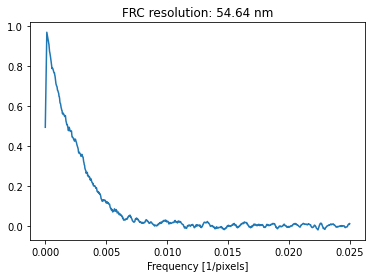

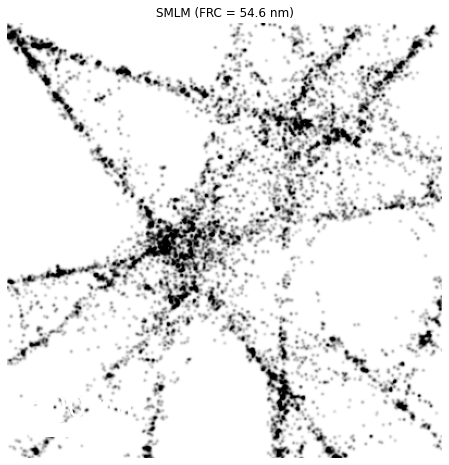

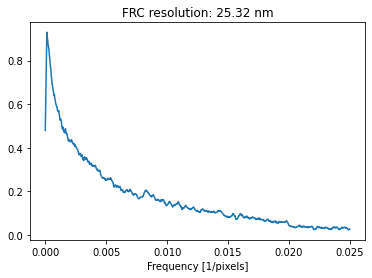

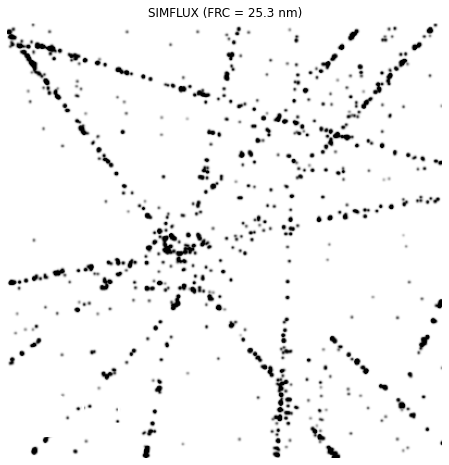

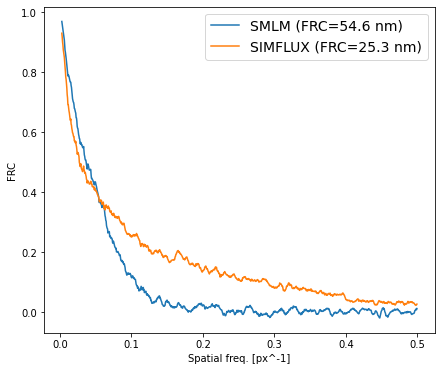

In [12]:
roi=(43,45),(63,65)
figsize=(8,8)
zoom = 20

datasets=[
    ('smlm', 'SMLM'),
    ('sf', 'SIMFLUX'),
    ]

frc_curves = []
frc_val = []

for fn,label in datasets:
    ds = Dataset.load(sfloc.result_dir + f'{fn}.hdf5')
    ds['pixelsize'] = pixelsize
    
    ds.crlb_filter(0.2)

    zoom=20    
    ds_frc, frc_curve = ds.frc(display=True, zoom=zoom, smooth=10)
    fig,ax=plt.subplots(figsize=figsize)
    ds.crop(*roi, silent=True).renderFigure(axes=ax,title=f'{label} (FRC = {ds_frc:.1f} nm)', 
                                           zoom=zoom, clip_percentile=98, scalebar_nm=500,
                                           scalebar_fontsize=30, cmap='gray_r')
    
    frc_curves.append(frc_curve)
    frc_val.append(ds_frc)
    
    plt.savefig(sfloc.result_dir + f"render-{fn}.png")
    plt.savefig(sfloc.result_dir + f"render-{fn}.svg")

freq = np.fft.fftfreq(zoom*W)
freq = freq[:W*zoom//2]

fig,ax=plt.subplots(figsize=(7,6))
for i in [0,1]:
    frc = frc_curves[i]
    frc = frc[5:W*zoom//2]
    plt.plot(freq[5:],  frc , label=f'{datasets[i][1]} (FRC={frc_val[i]:.1f} nm)')
plt.legend(fontsize=14)
plt.ylabel('FRC')
plt.xlabel('Spatial freq. [px^-1]')
plt.savefig(sfloc.result_dir+'frc-compare.svg')




## Render the different datasets (ground truth / smlm / sf)

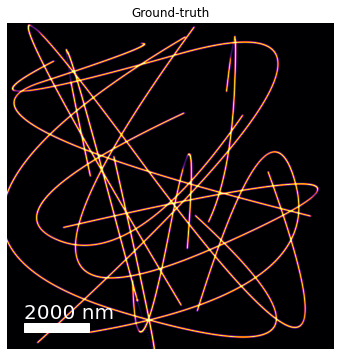

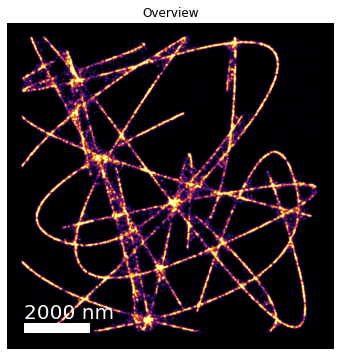

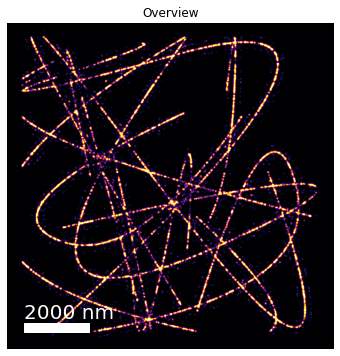

In [13]:


#%%
figsize=(6,6)
zoom = 6
render_args = dict(clip_percentile=97, 
                   pixelsize=pixelsize, 
                   scalebar_nm=2000, 
                   scalebar_fontsize=20)

# render ground truth

ds_gt = Dataset(len(pts), 2,(W,W), pixelsize=pixelsize)
ds_gt.pos[:,:2] = pts[:,:2]
ds_gt.photons[:] = 1

fig,ax=plt.subplots(figsize=figsize)
ds_gt.renderFigure(zoom=zoom,axes=ax, **render_args);
ax.set_title('Ground-truth')
plt.savefig(sfloc.result_dir+'render-gt.svg')


# render full view

fig,ax=plt.subplots(figsize=figsize)
ds = Dataset.load(sfloc.result_dir + f'smlm.hdf5')
ds.renderFigure(zoom=zoom, axes=ax, **render_args)
ax.set_title('Overview')
plt.savefig(sfloc.result_dir+'render-full-smlm.svg')


fig,ax=plt.subplots(figsize=figsize)
ds = Dataset.load(sfloc.result_dir + f'sf.hdf5')
ds.renderFigure(zoom=zoom, axes=ax, **render_args)
ax.set_title('Overview')
plt.savefig(sfloc.result_dir+'render-full-sf.svg')


# %%
